In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Adjust Price Paid

Predict what properties would have sold for, if sold in 2019

In [2]:
import os
import pandas as pd
from ast import literal_eval
from datetime import datetime
import matplotlib.ticker as plticker

filepath = os.path.realpath('../data/shared/prepared.csv')

In [3]:
df = pd.read_csv(filepath)
df['transaction_at'] = pd.to_numeric(pd.to_datetime(df['transaction_at']))

## Price paid distribution over time

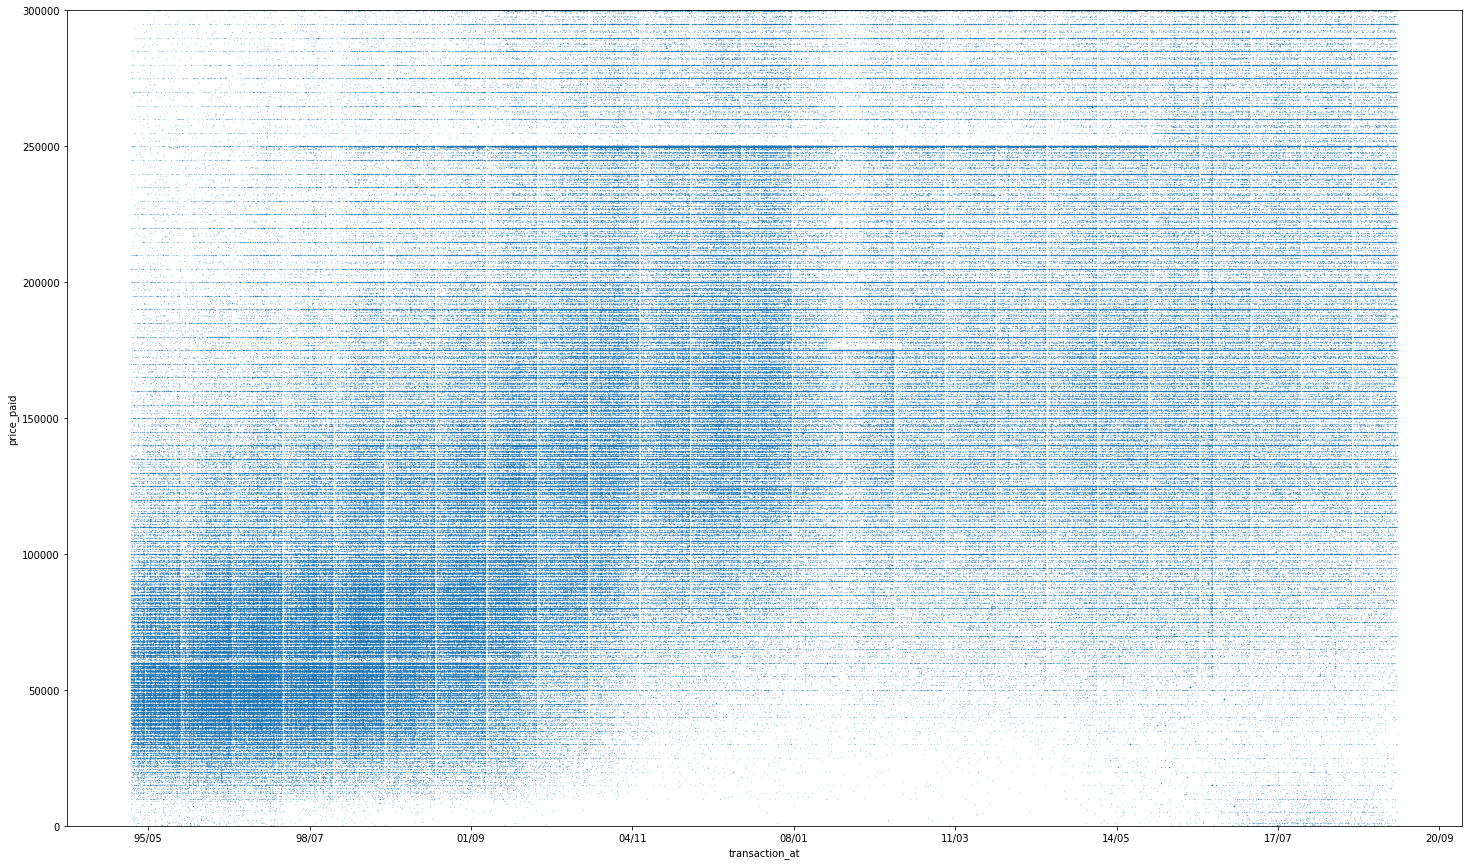

In [4]:
ax = df.plot.scatter('transaction_at', 'price_paid', s=0.01, figsize=(25,15))
ax.set_ylim(0, 300000)
ax.set_xticklabels([datetime.fromtimestamp(ts / 1e9).strftime('%y/%m') for ts in ax.get_xticks()])
ax

## Location distribution

Major cities like London / Bristol / Manchester, and some coastlines, are visible.

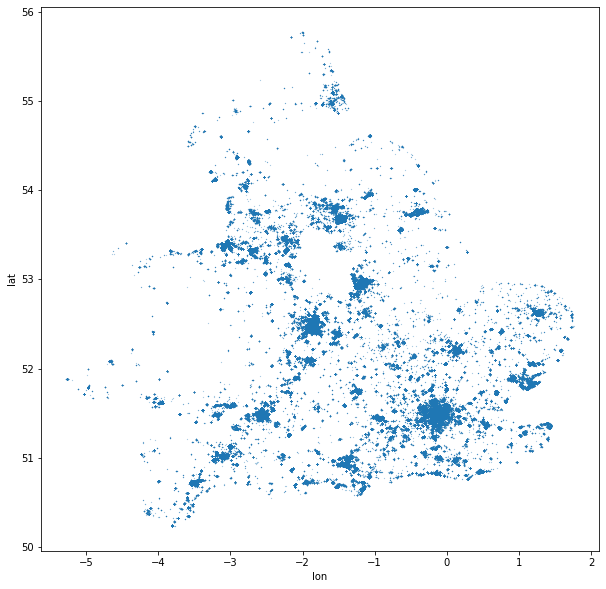

In [5]:
df.plot.scatter('lon', 'lat', s=0.02, figsize=(10,10))

In [6]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

## Training

Training a random forest to predict price paid based upon location & transaction date.

In [7]:
X = np.array(df[['lat', 'lon', 'transaction_at']])
y = np.array(df['price_paid'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=4)

# prevents overfitting
min_samples_leaf = 10

regr_rf = RandomForestRegressor(n_estimators=64, min_samples_leaf=min_samples_leaf,
                                random_state=2, n_jobs=-1)
regr_rf.fit(X_train, y_train)

y_pred_test = regr_rf.predict(X_test)
y_pred_train = regr_rf.predict(X_train)

In [8]:
import matplotlib.pyplot as plt

### Tuning overfit

Run predictions on both training & validation data to ensure the distributions look similar.

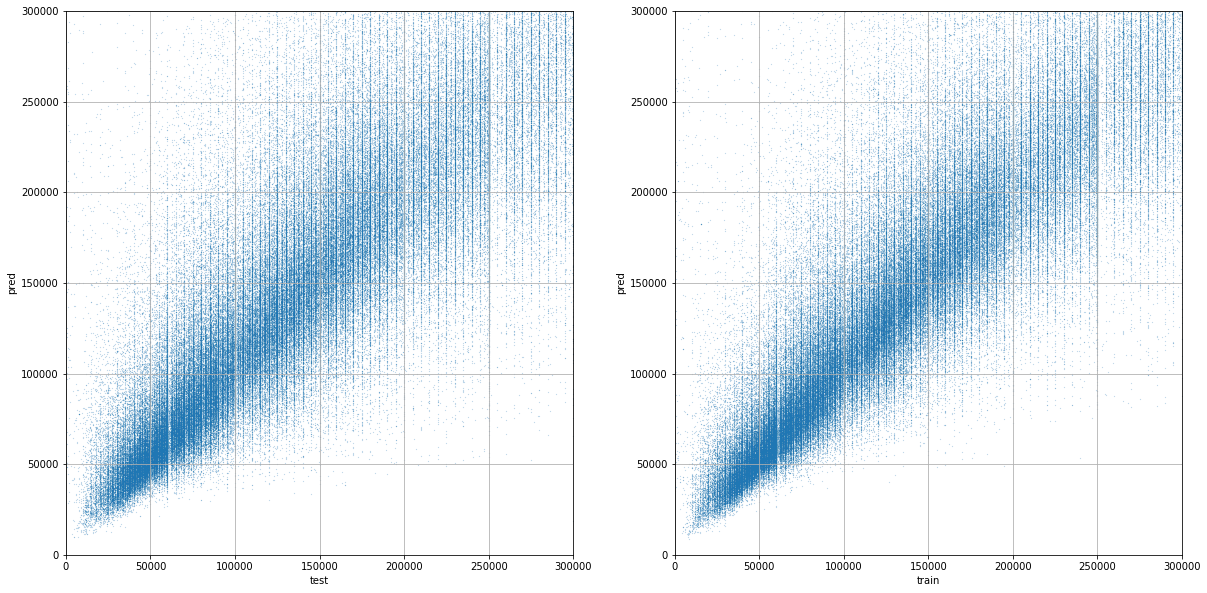

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

ax = axes[0]
pd.DataFrame({'test': y_test, 'pred': y_pred_test}).plot.scatter('test', 'pred', s=0.01, ax=ax)
ax.set_ylim(0, 300000)
ax.set_xlim(0, 300000)
ax.grid()

ax = axes[1]
pd.DataFrame({'train': y_train, 'pred': y_pred_train}).sample(frac=0.25).plot.scatter('train', 'pred', s=0.01, ax=ax)
ax.set_ylim(0, 300000)
ax.set_xlim(0, 300000)
ax.grid()

In [12]:
X_2019 = np.array(df[['lat', 'lon']])
today = np.datetime64(pd.to_datetime('2019-10-01'), 'ns').astype("float")
np.repeat(today, len(X_2019))
X_2019 = np.c_[X_2019, np.repeat(today, len(X_2019))]
X_2019

array([[ 5.21391131e+01, -4.59446286e-01,  1.56988800e+18],
       [ 5.21321279e+01, -4.65166230e-01,  1.56988800e+18],
       [ 5.21146255e+01, -4.98956071e-01,  1.56988800e+18],
       ...,
       [ 5.21137015e+01, -1.90448267e+00,  1.56988800e+18],
       [ 5.21642858e+01, -2.19858199e+00,  1.56988800e+18],
       [ 5.20901039e+01, -1.93776448e+00,  1.56988800e+18]])

## Predict price paid

If transaction was in 2019.

`price_paid_pred_2019` accounts for location and transaction date only.

`price_adjusted_2019` also takes the property's actual price paid into account. It is rounded down to the nearest £1000.

In [13]:
df['price_paid_pred'] = regr_rf.predict(X).astype("int")
df['price_paid_pred_2019'] = regr_rf.predict(X_2019).astype("int")
df['price_adjusted_2019'] = (df['price_paid_pred_2019'] * (df['price_paid'] / df['price_paid_pred']) / 1000).astype("int") * 1000

### Validating adjusted prices

The adjusted prices should remain stable over time, which they do.

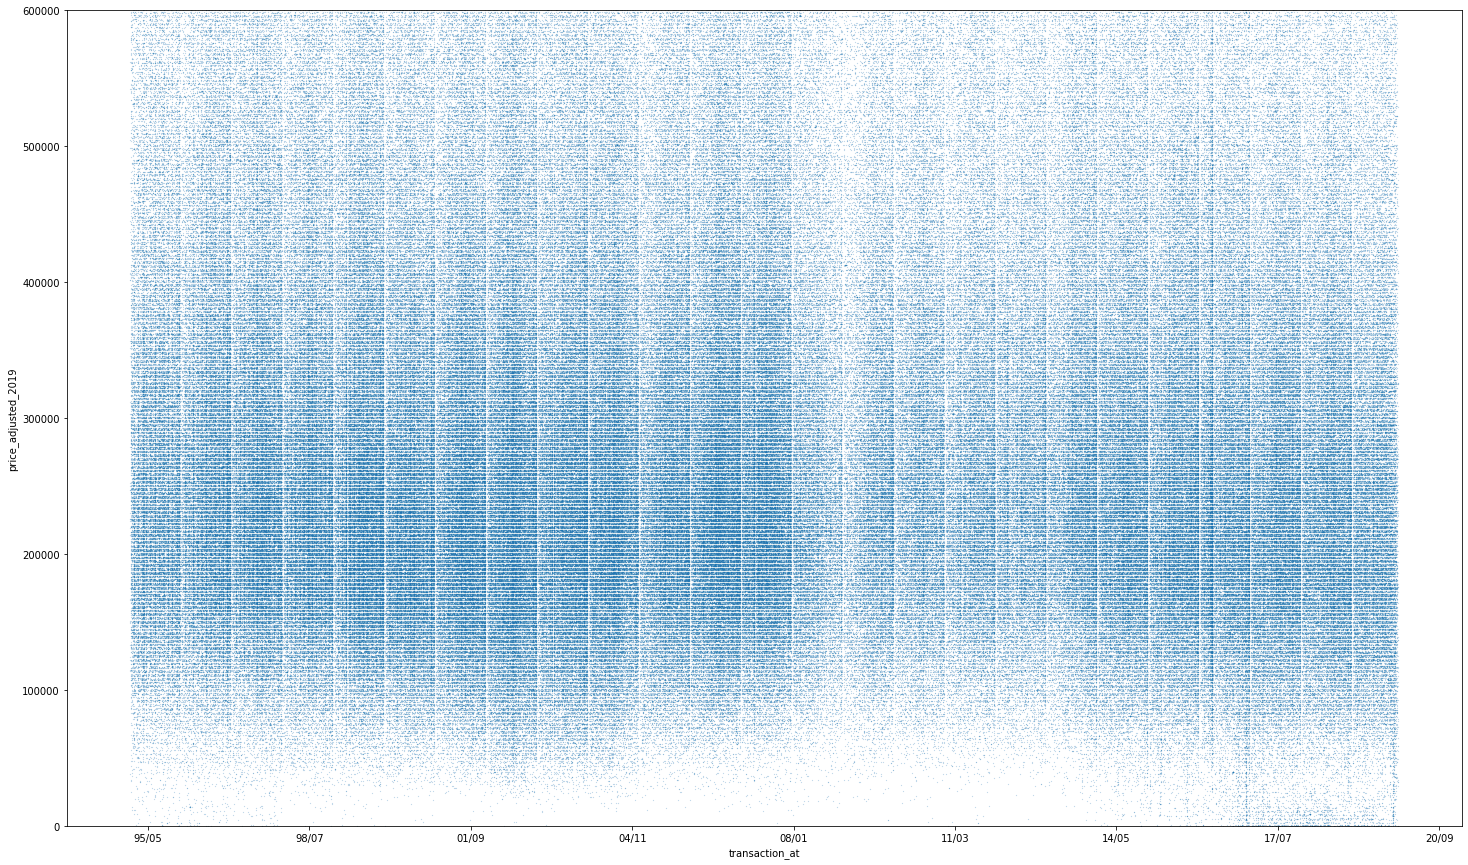

In [15]:
ax = df.plot.scatter('transaction_at', 'price_adjusted_2019', s=0.01, figsize=(25,15))
ax.set_ylim(0, 600000)
ax.set_xticklabels([datetime.fromtimestamp(ts / 1e9).strftime('%y/%m') for ts in ax.get_xticks()])
ax

### How significant were our adjustments?

The vast majority of houses appeared to increase in value. Two time periods with > average house sales are clearly visible.

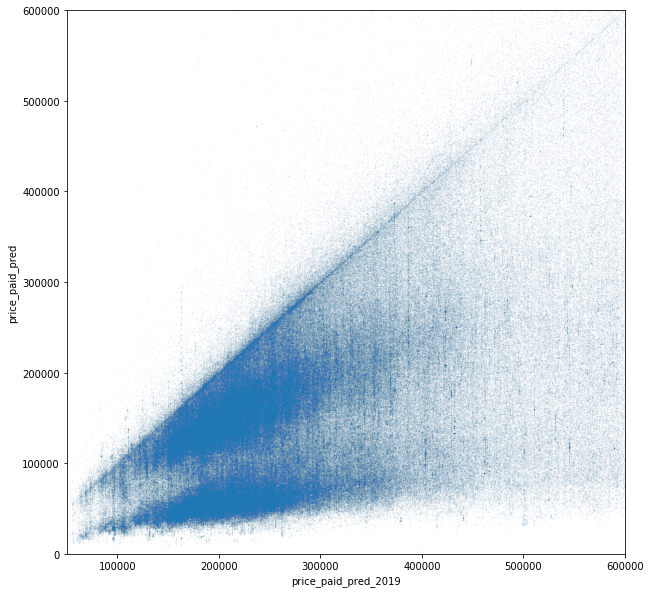

In [16]:
ax = df.plot.scatter('price_paid_pred_2019', 'price_paid_pred', s=0.00025, figsize=(10,10))
ax.set_xlim(50000, 600000)
ax.set_ylim(0, 600000)
ax

In [17]:
# df['transaction_at'] = pd.to_datetime(df['transaction_at'])

In [18]:
df

lat       lon  price_paid       transaction_at  \
0        52.139113 -0.459446      250000   809913600000000000   
1        52.132128 -0.465166       42000   793584000000000000   
2        52.114625 -0.498956       60000   808876800000000000   
3        51.912936 -0.500507       34500   812332800000000000   
4        51.916877 -0.677997       28500   809740800000000000   
...            ...       ...         ...                  ...   
1366945  52.086601 -1.961528      227000  1548892800000000000   
1366946  52.123197 -2.033200      252500  1561939200000000000   
1366947  52.113702 -1.904483      435000  1562112000000000000   
1366948  52.164286 -2.198582      271000  1563840000000000000   
1366949  52.090104 -1.937764      160000  1562630400000000000   

         price_paid_pred  price_paid_pred_2019  price_adjusted_2019  
0                  54233                794570              3662000  
1                  56266                430472               321000  
2                  79377                530769               401000  
3                  41292                237474               198000  
4                  42504                343812               230000  
...                  ...                   ...                  ...  
1366945           198178                203705               233000  
1366946           318676                323636               256000  
1366947           321009                320438               434000  
1366948           274032                297396               294000  
1366949           196972                204814               166000  

[1366950 rows x 7 columns]

In [ ]:
output = os.path.realpath('../data/shared/adjusted.csv')
df.to_csv(output)